# Goodness-of-fit tests
Following Coles (2001) _An Introduction to Statistical Modeling of Extreme Values_.

In [149]:
# load fitted GEV params
import os
import numpy as np
import wandb
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import genextreme

from hazardGAN import fig_utils, utils

plt.rcParams["font.family"] = "monospace"

from importlib import reload
reload(utils)

datas = ['wind_data'] # for now
block_size = 'daily'
evt_type = 'bm'
pot = (evt_type == "pot")

# load orgininal data and marginals
train, _, params, images, thresholds = utils.load_training_data(f"/Users/alison/Documents/DPhil/multivariate", train_size=2000, datas=datas, block_size=block_size, evt_type=evt_type)
train = utils.unpad(train).numpy()

n, h, w, c = train.shape
images = images.reshape(n, h * w, c)
train = train.reshape(n, h * w, c)
params = params.reshape(h * w, 3, c)

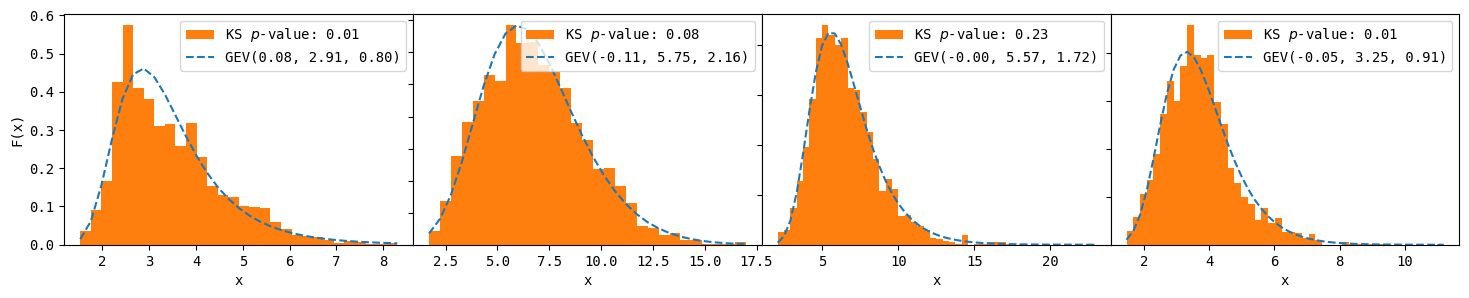

In [150]:
# histogram / compare fit
from scipy.stats import genextreme, goodness_of_fit

hist_kwargs = {'density': True}

fig = plt.figure(figsize=(18, 3))
gs = fig.add_gridspec(1, 4, wspace=0)
axs = np.array([fig.add_subplot(gs_i) for gs_i in gs])

pixels = np.array([0, 100, 150, 200])

for i, ax in enumerate(axs):
    param = params[pixels[i], ..., 0]
    gof = goodness_of_fit(genextreme, images[..., pixels[i], 0], statistic='ks',
                n_mc_samples=100,
                fit_params={'c': param[0],
                            'loc': param[1],
                            'scale': param[2]})
    
    
    n, bins, *_ = ax.hist(images[..., pixels[i], 0], color='C1', bins='auto',
                          label=r'KS $p$-value: {:.2f}'.format(gof.pvalue), **hist_kwargs)
    fit = genextreme.pdf(bins, *param)
    
    ax.plot(bins, fit, color='C0', linestyle='--',
            label='GEV({:.2f}, {:.2f}, {:.2f})'.format(-param[0], param[1], param[2]))
    ax.legend(loc='upper right')
    ax.set_ylabel('F(x)')
    ax.set_xlabel('x')
    ax.label_outer()
    
#fig.savefig('/Users/alison/Desktop/ks_test.png', bbox_inches='tight', dpi=300)

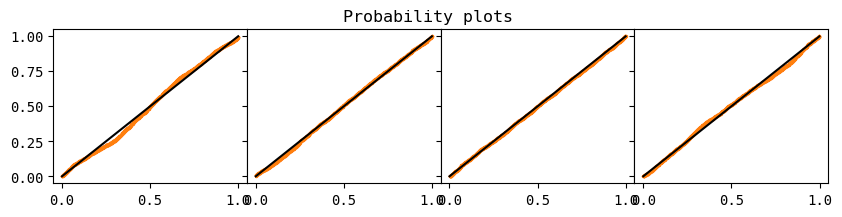

In [245]:
# GEV probability plots, Coles (2001) §3
fig = plt.figure(figsize=(10, 2))
gs = fig.add_gridspec(1, 4, wspace=0)
axs = np.array([fig.add_subplot(gs_i) for gs_i in gs])

pixels = np.array([0, 100, 150, 200])

def f(x):
    return x

for i, ax in enumerate(axs):
    param = params[pixels[i], ..., 0]
    x_i = np.array(sorted(images[..., pixels[i], 0]))
    ecdf_i = utils.ecdf(x_i)
    f_i = genextreme.cdf(x_i, *param)
    ax.scatter(ecdf_i, f_i, **scatter_kwargs)
    ax.plot(ecdf_i, ecdf_i, 'k')
    ax.label_outer()

fig.suptitle('Probability plots');


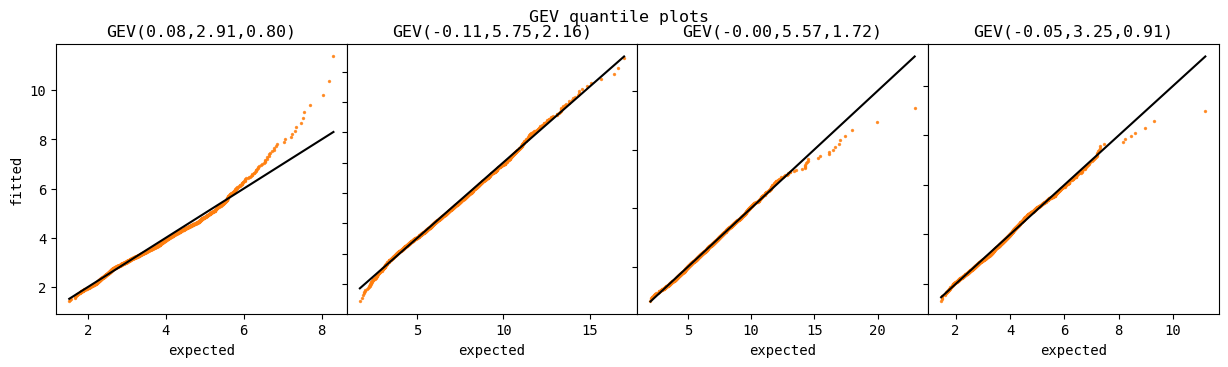

In [244]:
# GEV quantile plots, Coles (2001) §3
fig = plt.figure(figsize=(15, 3.5))
gs = fig.add_gridspec(1, 4, wspace=0)
axs = np.array([fig.add_subplot(gs_i) for gs_i in gs])

pixels = np.array([0, 100, 150, 200])

for i, ax in enumerate(axs):
    param = params[pixels[i], ..., 0]
    z_i = np.array(sorted(images[..., pixels[i], 0]))
    y = genextreme.ppf(utils.ecdf(z_i), *param)
    ax.scatter(z_i, y, **scatter_kwargs)
    ax.plot(z_i, z_i, 'k')
    ax.set_xlabel('expected')
    ax.set_ylabel('fitted')
    ax.set_title('GEV({:.2f},{:.2f},{:.2f})'.format(-param[0], param[1], param[2]))
    ax.label_outer()

fig.suptitle('GEV quantile plots');

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_18881/4029160820.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_18881/4029160820.py:9: RuntimeWarning: divide by zero encountered in log
  return mu + (sigma / ksi) * (1 - (-np.log(1 - p))**(-ksi))
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_18881/4029160820.py:9: RuntimeWarning: divide by zero encountered in power
  return mu + (sigma / ksi) * (1 - (-np.log(1 - p))**(-ksi))


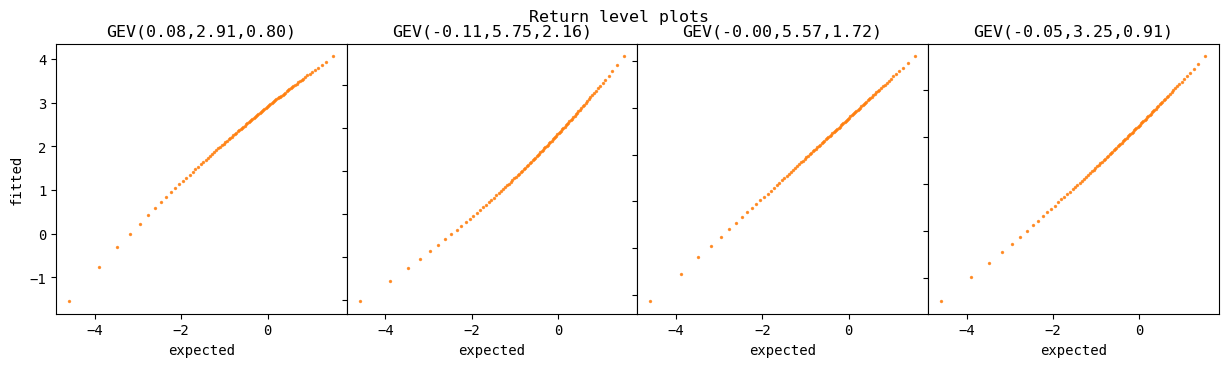

In [248]:
# return level plot, Coles (2001) §3
# GEV quantile plots, Coles (2001) §3
fig = plt.figure(figsize=(15, 3.5))
gs = fig.add_gridspec(1, 4, wspace=0)
axs = np.array([fig.add_subplot(gs_i) for gs_i in gs])

def f_z(p, c, mu,sigma):
    ksi = -c
    return mu + (sigma / ksi) * (1 - (-np.log(1 - p))**(-ksi))

def f_y(p):
    return np.log(-np.log(1 - p))
    

pixels = np.array([0, 100, 150, 200])

for i, ax in enumerate(axs):
    param = params[pixels[i], ..., 0]
    p = np.linspace(0, 1, 100)
    x = f_y(p)
    y = f_z(p, *param)
    
    ax.scatter(x, y, **scatter_kwargs)
#     ax.plot(z_i, z_i, 'k')
    ax.set_xlabel('expected')
    ax.set_ylabel('fitted')
    ax.set_title('GEV({:.2f},{:.2f},{:.2f})'.format(-param[0], param[1], param[2]))
    ax.label_outer()

fig.suptitle('Return level plots');

